In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.sparse import csc_array

import matplotlib.pyplot as plt
import matplotlib as mpl

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

from qs_mps.applications.Z2.exact_hamiltonian import *
from qs_mps.sparse_hamiltonians_and_operators import diagonalization, sparse_magnetization, sparse_pauli_x, sparse_pauli_z
from qs_mps.mps_class import MPS

# Periodic Boundary Condition Time Evolution

We are going to check the validity of the MPO for time evolution with the pbc hamiltonian. Hence, we are going to perform exact diagonalization with sparse matrices and compare the results.

## 1. Exact Time Evolution

We are going to perform two types of evolution:
- a. Start with the vacuum in the roughening, apply a string operator, evolve with the same hamiltonian
- b. Start with the string in the confined, evolve with the hamiltonian in the roughening region

### 1.a.1 Dual Hamiltonian in the vacuum roughening region

In [2]:
def dual_ham(l,L,g, cx: list=[], cy: list=[]):
    # degrees of freedom
    dof = l*L + 1

    # charges
    charges = np.ones((l,L+1))
    if len(cx) != 0:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1
    prod_charges = [1] + np.prod(charges[1:], axis=1).tolist()
    
    # initialize
    O = csc_array((2**dof, 2**dof), dtype=complex)
    H_sigmas = O
    H_taus = O
    H_plaquettes = O

    # first column of sigma are local
    for i in range(l):
        H_sigmas += sparse_pauli_z(n=i*L, L=dof)
    
    # horizontal zz interactions, we exclude the last column of sigmas
    for j in range(l):
        for i in range(L-1):
            H_sigmas += sparse_pauli_z(n=i+j*L, L=dof) @ sparse_pauli_z(n=(i+1)+j*L, L=dof)

    # horizontal zz interactions, last column of sigmas
    for j in range(l):
        H_sigmas += np.prod(prod_charges[:(j+1)]) * sparse_pauli_z(n=j*L+L-1, L=dof) @ sparse_pauli_z(n=l*L, L=dof)

    # vertical zz interactions 
    for j in range(L):
        for i in range(l):
            H_taus += np.prod(charges[(i+1)%l,:(j+1)]) * sparse_pauli_z(n=i*L+j, L=dof) @ sparse_pauli_z(n=((i+1)%l)*L+j, L=dof)

    # plaquette terms
    for i in range(l*L):
        H_plaquettes += sparse_pauli_x(n=i, L=dof)

    return - g * H_sigmas - g * H_taus - 1/g * H_plaquettes

In [3]:
l = 2
L = 3
g = 0.75
H_vr = dual_ham(l,L,g)
e, psi0 = diagonalization(H_vr, sparse=True)
print(len(e),psi0.shape, e)

1 (128, 1) [-12.3119519]


In [4]:
# charges
charges = np.ones((l,L+1))
# if len(cx) != 0:
#     charges[cy[0],cx[0]] = -1
#     charges[cy[1],cx[1]] = -1
prod_charges = [1] + np.prod(charges[1:], axis=1).tolist()
print(charges)
print(charges[1:])
print(prod_charges)

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[[1. 1. 1. 1.]]
[1, 1.0]


### 1.a.2 Application of the string operator

In [ ]:
def string_operator(cx: list=None, cy: list=None):
    
    
    pass

### 1.a.3 Evolution with the Dual Hamiltonian in the vacuum roughening region

### 1.b.1 Dual Hamiltonian in the string confined region

In [77]:
l = 2
L = 3
g = 1
cx = [1,2]
cy = [0,0]
H_sc = dual_ham(l,L,g,cx,cy)
e, psi0 = diagonalization(H_sc, sparse=True)
print(len(e),psi0.shape, e)
psi0 = psi0.reshape(2**(l*L+1))

1 (128, 1) [-12.99292927]


### 1.b.2 Evolution with Dual Hamiltonian in the string roughening region

In [94]:
l = 2
L = 3
g_r = 1
cx = [1,2]
cy = [0,0]
steps = 100
delta = 100
from scipy.sparse.linalg import expm

H_sr = dual_ham(l,L,g_r,cx,cy)

# observable, e.g. fidelity
fid = []
for N in range(steps):
    t = N*delta
    print(f"exact evolution at time: {t}")
    U_sr = expm(-1j*t*H_sr)
    psi_ev = U_sr @ psi0
    overlap = (psi_ev.T.conjugate() @ psi0).real
    fid.append(overlap)
    print(f"fidelity: {overlap}")

exact evolution at time: 0
fidelity: 0.9999999999999998
exact evolution at time: 100
fidelity: 0.24194009251962573
exact evolution at time: 200
fidelity: -0.882929983263733
exact evolution at time: 300
fidelity: -0.6691724161976034
exact evolution at time: 400
fidelity: 0.5591307106911051
exact evolution at time: 500
fidelity: 0.939724687947157
exact evolution at time: 600
fidelity: -0.1044165548003409
exact evolution at time: 700
fidelity: -0.9902497898033519
exact evolution at time: 800
fidelity: -0.37474569672629304
exact evolution at time: 900
fidelity: 0.8089177727320374
exact evolution at time: 1000
fidelity: 0.7661649782757753
exact evolution at time: 1100
fidelity: -0.4381857212702126
exact evolution at time: 1200
fidelity: -0.9781943661668875
exact evolution at time: 1300
fidelity: -0.035143149631403914
exact evolution at time: 1400
fidelity: 0.9611892924152299
exact evolution at time: 1500
fidelity: 0.5002436023094602
exact evolution at time: 1600
fidelity: -0.719131325574596

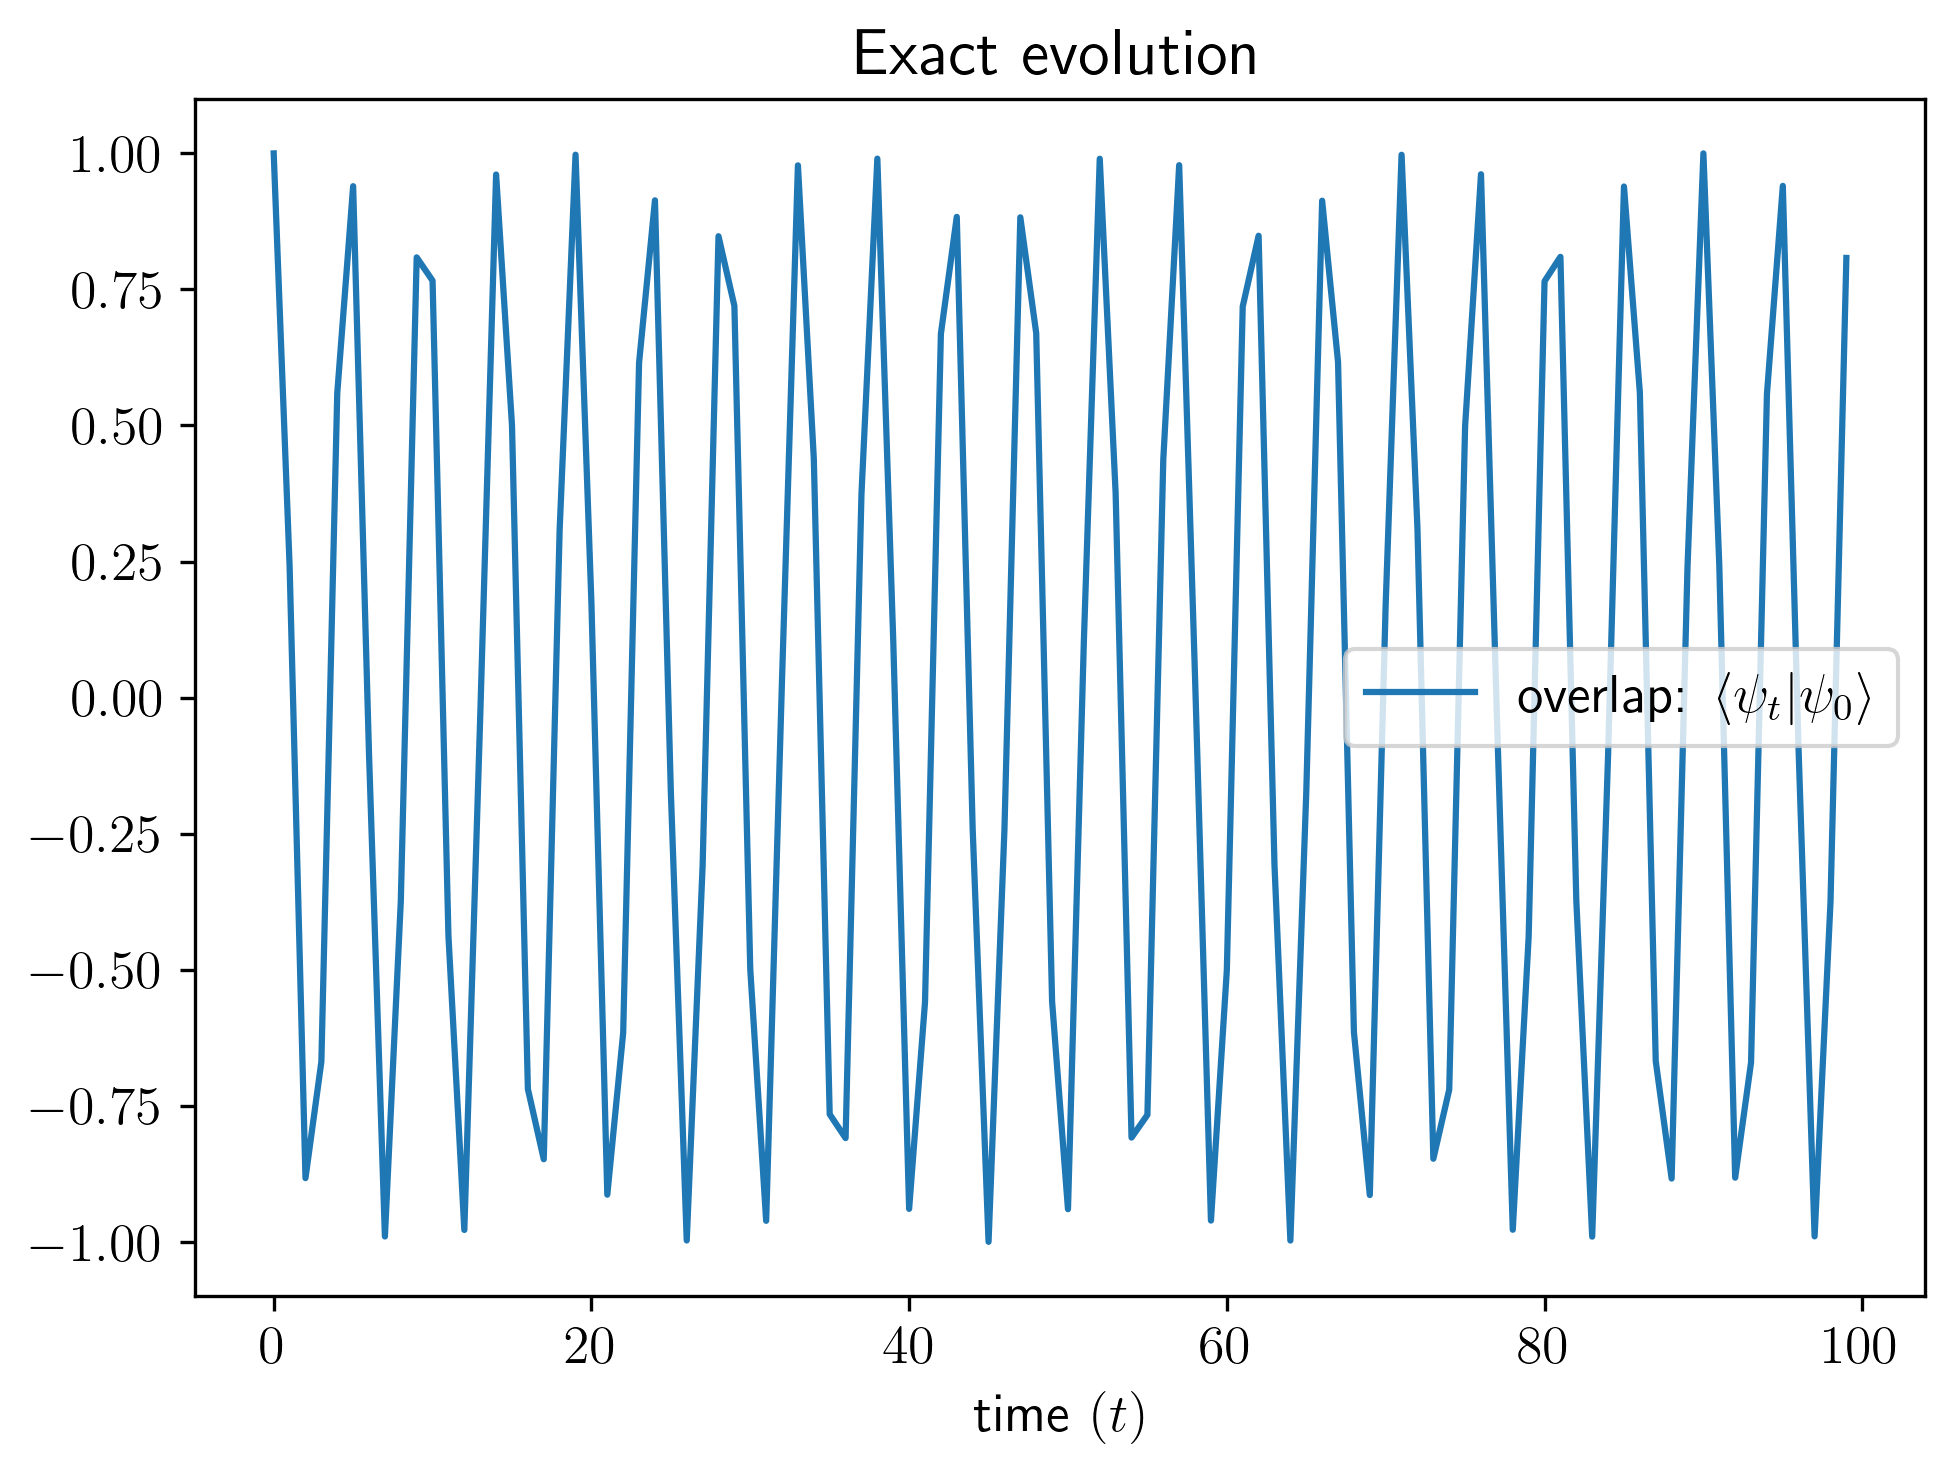

In [95]:
plt.plot(range(steps),fid, label="overlap: $\\langle \\psi_t | \\psi_0 \\rangle$")
plt.title("Exact evolution")
plt.xlabel("time $(t)$")
plt.legend()
plt.show()

In [90]:
l = 2
L = 3
g_r = 1
cx = [1,2]
cy = [0,0]
steps = 10
delta = 10
from scipy.sparse.linalg import expm

H_sr = dual_ham(l,L,g_r,cx,cy)

# initialize psi and evolution trotter op
psi_ev = psi0
U_sr = expm(-1j*delta*H_sr)

# observable, e.g. fidelity
fid = []
for N in range(steps):
    t = N*delta
    print(f"exact evolution at time: {t}")
    psi_ev = U_sr @ psi_ev
    overlap = (psi_ev.T.conjugate() @ psi0).real
    fid.append(overlap)
    print(f"fidelity: {overlap}")

exact evolution at time: 0
fidelity: -0.43208405750111045
exact evolution at time: 10
fidelity: -0.6266067345067703
exact evolution at time: 20
fidelity: 0.973577618107532
exact evolution at time: 30
fidelity: -0.21472800054155816
exact evolution at time: 40
fidelity: -0.7880165266413539
exact evolution at time: 50
fidelity: 0.8957067569598194
exact evolution at time: 60
fidelity: 0.013975306884646432
exact evolution at time: 70
fidelity: -0.9077837715669175
exact evolution at time: 80
fidelity: 0.7705024838199446
exact evolution at time: 90
fidelity: 0.2419400925197217


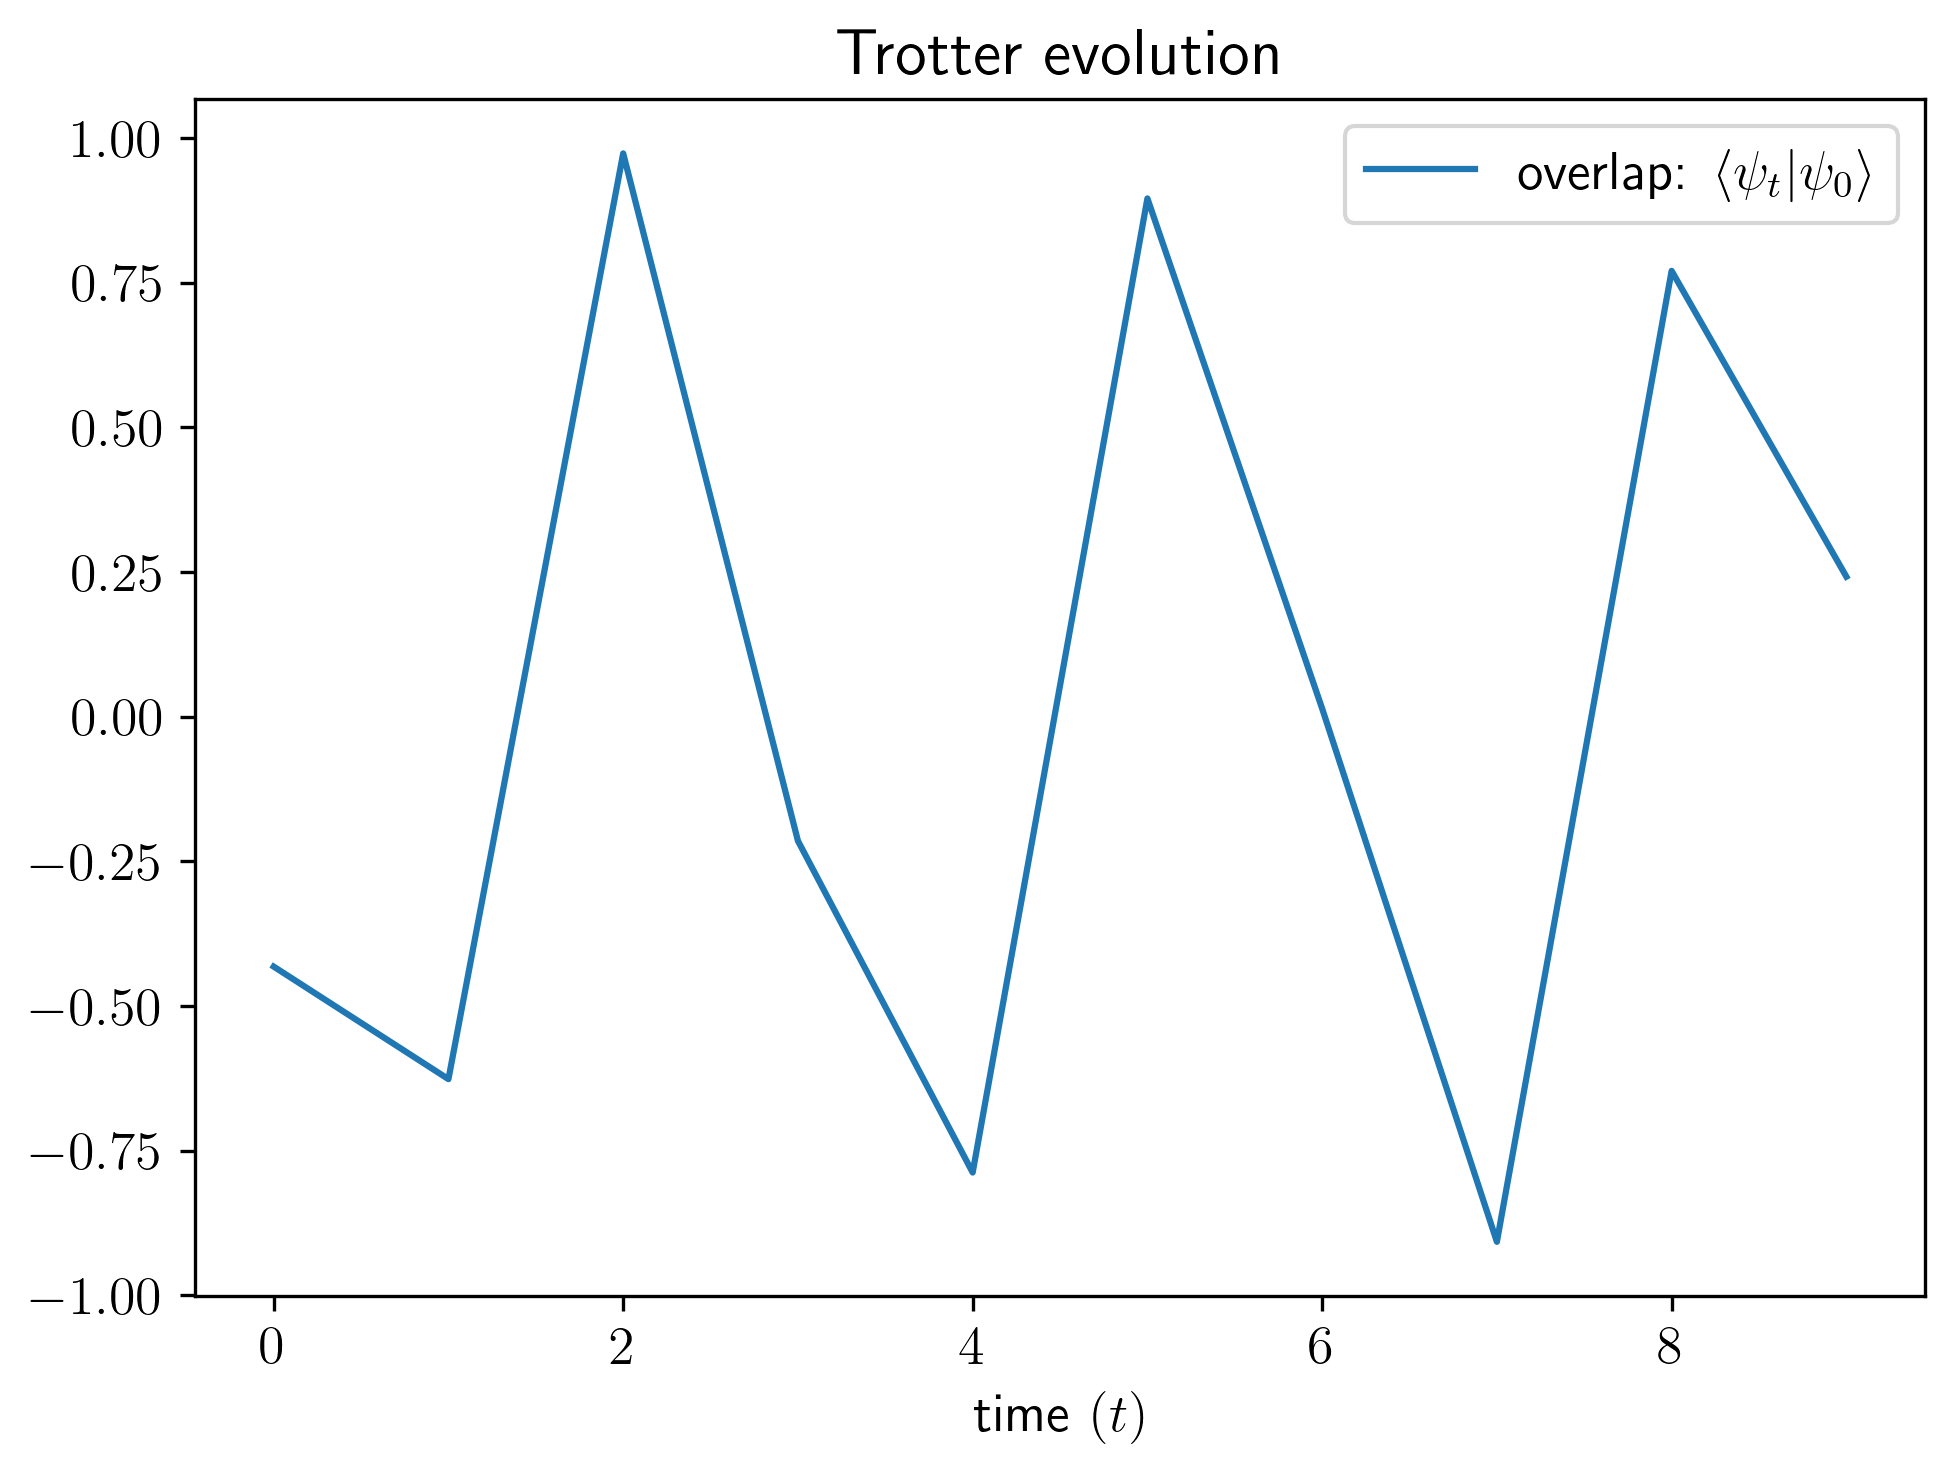

In [91]:
plt.plot(range(steps),fid, label="overlap: $\\langle \\psi_t | \\psi_0 \\rangle$")
plt.title("Trotter evolution")
plt.xlabel("time $(t)$")
plt.legend()
plt.show()

## 2. Build evolution MPO for PBC

## 3. Compare MPO and Exact results